# Create Baselines

In [2]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [4]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [5]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [6]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [7]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

In [8]:
bool_wb = xr.open_dataset(data_dir / "RUNOFF/bool_water_balance_20pct.nc")
bool_wb = bool_wb.to_array().isel(variable=0).drop("variable")
bool_wb

<xarray.DataArray (station_id: 671)>
array([False,  True, False, False,  True,  True, False, False, False,
        True, False, False, False,  True,  True, False,  True, False,
        True,  True,  True, False,  True,  True, False,  True, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False, False,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True, False,  True,  True, False, False,
       False, False, False, False, False, False,  True,  True,  True,
       False,  True,  True,  True, False, False,  True, False,  True,
        True, False, False, False, False, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True, False,  True,  True,
        True, False, False,  True,  True,  True, False, False, False,
       False,  True,  True,  True,  True, False, False,  True,  True,
       False,  True, False,  True,  True, False, False,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False,  True,  True,  True, False,
       False, False,  True,  True, False,  True, False, False,  True,
        True, False, False,  True,  True,  True, False,  True,  True,
        True, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False,  True,  True,  True, False, False, False, False,  True,
       False, False,  True, False,  True,  True, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
        True, False,  True, False,  True, False,  True,  True,  True,
        True, False, False,  True, False,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True, False, False,  True, False, False, False, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False, False,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False, False, False,  True, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True, False, False,  True, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True, False, False, False,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  

# Read in AWS Models

In [9]:
# ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
# ealstm_preds = xr.open_dataset(data_dir / "runs/ensemble/data_ENS.csv")
ealstm_ensemble_df = pd.read_csv(data_dir / "runs/ensemble_EALSTM/data_ENS.csv").drop("Unnamed: 0", axis=1)
ealstm_ensemble_df["time"] = pd.to_datetime(ealstm_ensemble_df["time"])
ealstm_preds = ealstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()

ealstm_preds["station_id"] = [int(sid) for sid in ealstm_preds["station_id"]]

In [10]:
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble_pet/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble_pet_trainperiod/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df["time"] = pd.to_datetime(lstm_ensemble_df["time"])
lstm_ensemble = lstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()
lstm_preds = lstm_ensemble

# Fuse Data

In [11]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

In [12]:
fuse_ds = fuse_ds.sel(time=slice('1998-01-01', '2009-01-01'))

In [13]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["discharge_spec"]
).rename("obs")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

# Match Station / Times

In [14]:
all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)

lstm_preds = lstm_preds.sel(station_id=all_stations_lstm, time=fuse_data.time)
ealstm_preds = ealstm_preds.sel(station_id=all_stations_ealstm, time=fuse_data.time)

# Join all models

In [15]:
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict
from scripts.drafts.calculate_error_scores import DeltaError

# calculate all error metrics
processor = DeltaError(ealstm_preds, lstm_preds, fuse_data)
all_preds = processor.all_preds

In [16]:
!git pull
# BENCHMARKS
# 1) Persistence
all_preds["persistence"] = ds["discharge_spec"].shift(time=1).sel(station_id=all_preds.station_id, time=all_preds.time)

# 2) DayofYear Climatology
from src.utils import create_shape_aligned_climatology

climatology_unit = "month"

climatology_doy = ds["discharge_spec"].groupby("time.dayofyear").mean()
climatology_doy = create_shape_aligned_climatology(ds, climatology_doy.to_dataset(), variable="discharge_spec", time_period="dayofyear")

climatology_mon = ds["discharge_spec"].groupby("time.month").mean()
climatology_mon = create_shape_aligned_climatology(ds, climatology_mon.to_dataset(), variable="discharge_spec", time_period="month")
    
all_preds["climatology_doy"] = climatology_doy.sel(station_id=all_preds.station_id, time=all_preds.time)["discharge_spec"]
all_preds["climatology_mon"] = climatology_mon.sel(station_id=all_preds.station_id, time=all_preds.time)["discharge_spec"]

all_preds

Already up to date.


<xarray.Dataset>
Dimensions:          (station_id: 519, time: 4018)
Coordinates:
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
  * time             (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    TOPMODEL         (station_id, time) float64 ...
    ARNOVIC          (station_id, time) float64 ...
    PRMS             (station_id, time) float64 ...
    SACRAMENTO       (station_id, time) float64 ...
    EALSTM           (station_id, time) float64 1.719 2.034 ... 1.076 1.041
    obs              (station_id, time) float64 2.14 1.81 4.57 ... 2.53 2.33
    LSTM             (station_id, time) float64 1.526 1.759 2.45 ... 1.536 1.48
    persistence      (time, station_id) float64 3.49 3.08 3.62 ... 0.42 1.2 2.53
    climatology_doy  (time, station_id) float64 3.111 3.372 3.54 ... 2.833 4.293
    climatology_mon  (time, station_id) float64 2.735 3.358 ... 3.557 5.545

# ALL Errors

In [17]:
# if "all_errors" not in globals().keys():
all_errors = calculate_all_data_errors(all_preds)
all_metrics = get_metric_dataframes_from_output_dict(all_errors)
all_metrics.keys()

Errors: 100%|██████████| 9/9 [01:45<00:00, 11.73s/it]


dict_keys(['nse', 'kge', 'mse', 'bias', 'log_nse', 'inv_kge', 'abs_pct_bias', 'mape', 'mam30_ape', 'rmse'])

In [22]:
# display(all_errors["climatology_doy"].median())
# display(all_errors["climatology_mon"].median())

# Improvement over the baselines

In [24]:
all_errors.keys()

dict_keys(['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', 'EALSTM', 'LSTM', 'persistence', 'climatology_doy', 'climatology_mon'])

In [52]:
from typing import Dict, DefaultDict

model = all_model_strs[0]
baseline = "persistence"
assert baseline in [k for k in all_errors.keys() if k not in all_model_strs]

def calculate_pct_difference_dicts(all_errors: Dict[str, pd.DataFrame]) -> DefaultDict[str, Dict[str, pd.DataFrame]]:
    all_model_strs = ['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', 'EALSTM', 'LSTM']
    pct_difference_dict = defaultdict(dict)

    for baseline in ['persistence', 'climatology_doy', 'climatology_mon']:
        for model in all_model_strs:

            metrics = ["nse", "kge", "log_nse", "inv_kge", "abs_pct_bias", "mape", "mam30_ape", "rmse"]
            pct_difference = 100 * ((all_errors[model] - all_errors[baseline]) / all_errors[baseline]).loc[:, metrics]
            pct_difference_dict[baseline][model] = pct_difference
    return pct_difference_dict

In [54]:
pct_difference_dict = calculate_pct_difference_dicts(all_errors)

In [55]:
pct_difference_dict

defaultdict(dict,
            {'persistence': {'TOPMODEL':                    nse        kge     log_nse      inv_kge   abs_pct_bias  \
              station_id                                                                  
              1001         30.103121   3.037808  -32.505218  -115.181116    1815.938399   
              2001         83.659519  11.883329   -7.807041   -38.250366   29582.343267   
              2002         54.950698   4.620891  -40.355582  -226.032327   33382.904916   
              3003        423.421635  45.606182   13.047048   -58.366620     513.366592   
              4001         -8.603176 -18.118881  -20.315046   -40.554339  168407.899244   
              ...                ...        ...         ...          ...            ...   
              97002        70.629524   3.867818  -20.794712   -83.254998    6577.243350   
              101002      118.189388  19.286440  -34.505414   -42.170688    4523.564901   
              101005      229.999295  13.2892

# CDF Plotting

In [19]:
from typing import Optional, List, Tuple

ml_sids = all_metrics["nse"].index.values

def plot_cdf(
    error_data, metric: str = "", 
    sids: List[int] = ml_sids, 
    clip: Optional[Tuple] = None, 
    ax = None, 
    title=None,
    models: Optional[List[str]] = None,
):
    colors = sns.color_palette()
    kwargs_dict = {
        "TOPMODEL": {"linewidth": 1, "alpha":0.8, "color": colors[2], "clip": clip},
        "PRMS": {"linewidth": 1, "alpha":0.8, "color": colors[3], "clip": clip},
        "ARNOVIC": {"linewidth": 1, "alpha":0.8, "color": colors[4], "clip": clip},
        "VIC": {"linewidth": 1, "alpha":0.8, "color": colors[4], "clip": clip},
        "SACRAMENTO": {"linewidth": 1, "alpha":0.8, "color": colors[5], "clip": clip},
        "gr4j": {"linewidth": 1, "alpha":0.8, "color": colors[9], "clip": clip},
        "climatology": {"linewidth": 1, "alpha":0.8, "color": colors[6], "clip": clip, "ls": "-."},
        "climatology_doy": {"linewidth": 1, "alpha":0.8, "color": colors[6], "clip": clip, "ls": "-."},
        "climatology_mon": {"linewidth": 1, "alpha":0.8, "color": colors[8], "clip": clip, "ls": "-."},
        "persistence": {"linewidth": 1, "alpha":0.8, "color": colors[7], "clip": clip, "ls": "-."},
        "EALSTM": {"linewidth": 3, "alpha": 1, "color": colors[1], "clip": clip},
        "LSTM": {"linewidth": 3, "alpha": 1, "color": colors[0], "clip": clip},
    }
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 3))
    
    if models is None:
        models = [c for c in error_data.columns if c in kwargs_dict]
    for ix, model in enumerate(models):
        sns.kdeplot(
            error_data[model].dropna(),
            cumulative=True,
            legend=False, ax=ax,
            label=f"{model}: {error_data[model].median():.2f}",
            **kwargs_dict[model]
        )

        ax.axvline(error_data[model].dropna().median(), ls="--", color=kwargs_dict[model]["color"])

    ax.set_xlim(clip)
    ax.set_xlabel(metric)
    ax.set_ylabel("Cumulative density")
    title = title if title is not None else f"Cumuluative Density Function of Station {metric} Scores"
    ax.set_title(title)
    sns.despine()
    plt.legend()
    
    return ax

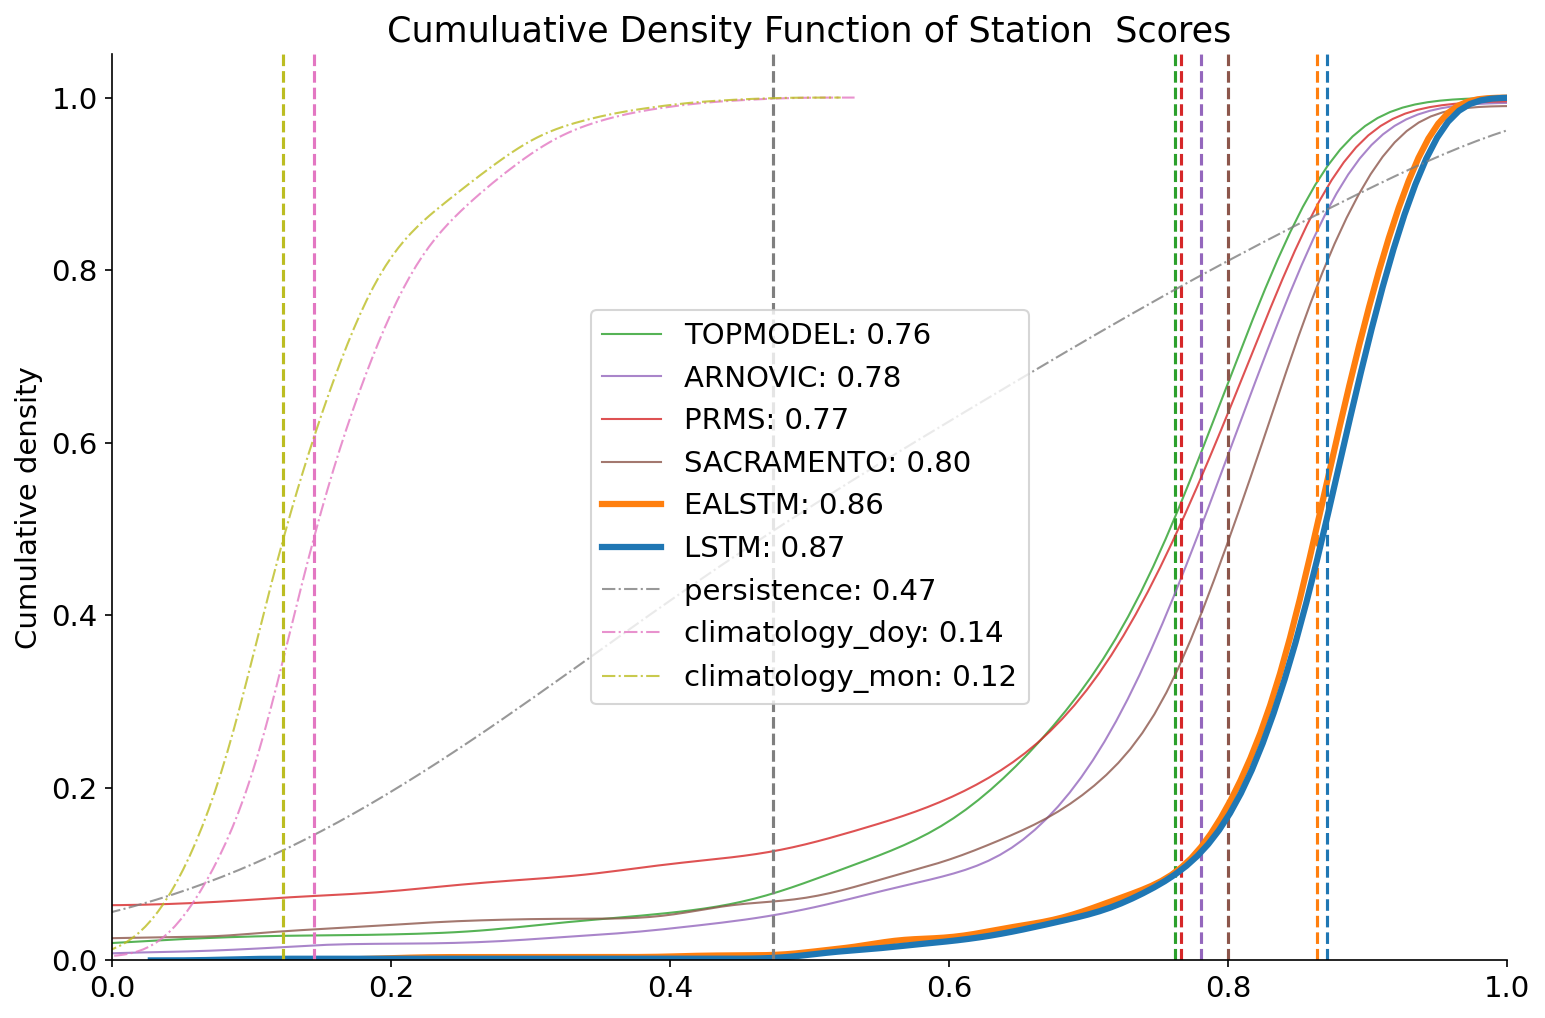

In [20]:
models = None

f, ax = plt.subplots(figsize=(12, 8))
plot_cdf(all_metrics["nse"], clip=(0, 1), ax=ax, models=models);

In [21]:
# Our own efficiency metric rather than calibrating on the mean = (variance)
# 1 - ( / )

SyntaxError: invalid syntax (<ipython-input-21-c15daa65e3b6>, line 2)

# Spatial Data

In [ ]:
import geopandas as gpd

shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}  # 4277  27700

# points_gdf = 
d = static[["gauge_lat", "gauge_lon"]].to_dataframe()
points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
points.name = "geometry"

In [ ]:
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

uk = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

# Read in GR4J Models

In [ ]:
csvs = list((data_dir / "GR4J_data/single").glob("HD_FlowSingle*.csv"))
metadata = pd.read_csv(list((data_dir / "GR4J_data/single").glob("ALL*.csv"))[0], index_col=0)
metadata = metadata.set_index("catchID")
print(metadata.columns)

In [ ]:
gr4j_df = pd.concat([
    pd.read_csv(csv, index_col=0).rename(
        {"catchID": "station_id", "Date": "time", "Flow_Top_Calib": "sim", "Max_500": "ensemble_upper", "Min_500": "ensemble_lower"}, 
        axis=1
    ).astype({"time": "datetime64[ns]"})
    for csv in csvs
])

gr4j_df.head()

In [ ]:
gr4j = gr4j_df.set_index(["station_id", "time"]).to_xarray()
obs = ds["discharge_spec"].sel(station_id=np.isin(ds.station_id.values, gr4j.station_id.values), time=np.isin(ds.time, gr4j.time)).rename("obs")

In [ ]:
gr4j = gr4j.sel(station_id=obs.station_id, time=obs.time).merge(obs)

In [ ]:
# lstm_preds.sel(station_id=np.isin(lstm_preds.station_id.values, [int(i) for i in metadata.index]))

gr4j_lstm_preds = lstm_ensemble.sel(station_id=np.isin(lstm_ensemble.station_id.values, gr4j.station_id.values))
gr4j_lstm_preds = (gr4j_lstm_preds.rename({"sim": "LSTM"}))

all_gr4j = gr4j.sel(time=gr4j_lstm_preds.time).rename({"sim": "gr4j"}).drop(["ensemble_lower","ensemble_upper"]).merge(gr4j_lstm_preds.drop("obs"))

In [ ]:
lstm_gr4j_errors = calculate_all_data_errors(all_gr4j)
lstm_gr4j_metrics = get_metric_dataframes_from_output_dict(lstm_gr4j_errors)
lstm_gr4j_errors = lstm_gr4j_errors["lstm"]

In [ ]:
nse_data = lstm_gr4j_metrics["nse"]
f, ax = plt.subplots();
plot_cdf(nse_data, clip=(0, 1), ax=ax, models=["LSTM", "gr4j"]);

In [ ]:
# nse_data